# Segmenting the picture of greek coins in regions
This example uses Spectral clustering on a graph created from voxel-to-voxel difference on an image to break this image into multiple partly-homogeneous regions.
* This procedure (spectral clustering on an image) is an efficient approximate solution for finding normalized graph cuts.
* There are three options to assign labels:
    * kmeans spectral clustering clusters samples in the embedding space using a kmeans algorithm
    * discrete iteratively searches for the closest partition space to the embedding space of spectral clustering.
    * cluster_qr assigns labels using the QR factorization with pivoting the directly  partition in the embedding space.

In [27]:
# Authors : The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

In [28]:
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.data import coins
from skimage.transform import rescale

from sklearn.cluster import spectral_clustering
from sklearn.feature_extraction import image


In [29]:
#load the coins as a numpy array
orig_coins = coins()

* Resize it to 20% fo the original size to speed up the processing
* Applying a Gaussian filter for smoothing prior to down-scaling
* reduces aliasing artifacts

In [ ]:
smoothened_coins = gaussian_filter(orig_coins, sigma=3)
rescaled_coins = rescale(smoothened_coins, 0.2, mode="reflect", anti_aliasing=False)

#### Convert the image into a graph with the value of the gradient on the edges

In [24]:
graph = image.img_to_graph(rescaled_coins)

#### Take a decreasing function of the gradient : an exponential
* The smaller beta is, the more independent the segmentation is of the actual image. For beta = 1, the segmentation is close to a voronoi
* The number of segmented regions to display needs to be chosen manually/
* The current version of 'spectral_clustering' does not support determining
* the number of good quality clusters automatically.

In [25]:
beta = 10
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

n_regions = 26


### Compute and visualize the resulting regions
* Computing a few extra eigenvectors may speed up the eigen_solver.
* The spectral clustering quality may also benefit from requesting extra regions for sementation

Spectral clustering: kmeans, 1.33s


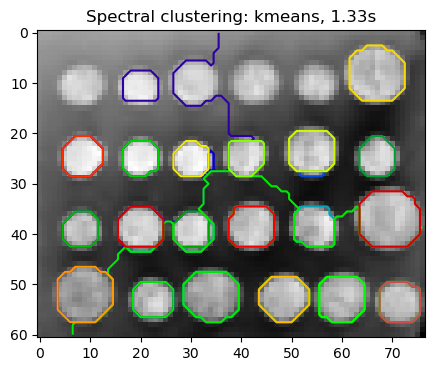

Spectral clustering: discretize, 0.95s


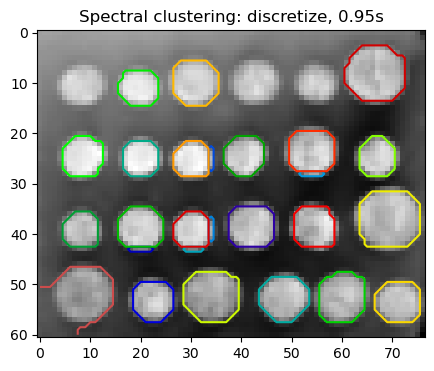

Spectral clustering: cluster_qr, 0.93s


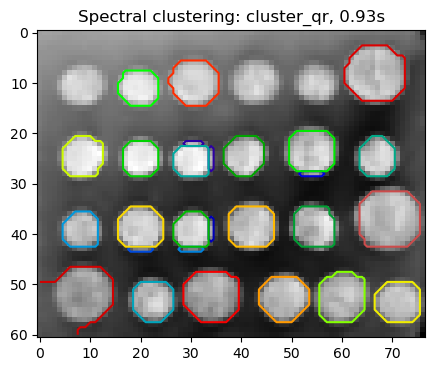

In [26]:
# Computing a few extra eigenvectors may speed up the eigen_solver.
# The spectral clustering quality may also benefit from requesting
# extra regions for segmentation.
n_regions_plus = 3

# Apply spectral clustering using the default eigen_solver='arpack'.
# Any implemented solver can be used: eigen_solver='arpack', 'lobpcg', or 'amg'.
# Choosing eigen_solver='amg' requires an extra package called 'pyamg'.
# The quality of segmentation and the speed of calculations is mostly determined
# by the choice of the solver and the value of the tolerance 'eigen_tol'.
# TODO: varying eigen_tol seems to have no effect for 'lobpcg' and 'amg' #21243.
for assign_labels in ("kmeans", "discretize", "cluster_qr"):
    t0 = time.time()
    labels = spectral_clustering(
        graph,
        n_clusters=(n_regions + n_regions_plus),
        eigen_tol=1e-7,
        assign_labels=assign_labels,
        random_state=42,
    )

    t1 = time.time()
    labels = labels.reshape(rescaled_coins.shape)
    plt.figure(figsize=(5, 5))
    plt.imshow(rescaled_coins, cmap=plt.cm.gray)

    plt.xticks(())
    plt.yticks(())
    title = "Spectral clustering: %s, %.2fs" % (assign_labels, (t1 - t0))
    print(title)
    plt.title(title)
    for l in range(n_regions):
        colors = [plt.cm.nipy_spectral((l + 4) / float(n_regions + 4))]
        plt.contour(labels == l, colors=colors)
        # To view individual segments as appear comment in plt.pause(0.5)
plt.show()

# TODO: After #21194 is merged and #21243 is fixed, check which eigen_solver
# is the best and set eigen_solver='arpack', 'lobpcg', or 'amg' and eigen_tol
# explicitly in this example.